# JABS Tutorial

# Purpose/Expectations

The contents of this course will grant insight into important characteristics while trainig behavioral classifiers. The usage of JABS code in this tutorial is strictly limited to reading in project annotations and feature vectors.

Within this tutorial, you will be provided with 2 example annotated projects that contain sparse labels that will be used for training and dense labels that you will use for final evaluation of your best model.

Expected knowledge before coming doing the course
* Familiarity with animal pose data and frame-level features derived from that data
* Basic python experience
* Some numpy experience
* Familiarity with generating plots in python (preference to using plotnine, which is ggplot-style syntax)

Please feel free to use the "solution" links when the programming experience is above your knowledge.

Expected takeaways of the course
* Learn the core process to train a frame-wise predictor of behavior
* Become familiar with key components to take into account when training these types of classifiers
* Gain insight for some of the design decision considerations our group integrated into the JABS software

## Step 0
Import a lot of libraries that we will be using in this tutorial

In [1]:
# JABS install directory
import sys
from itertools import chain

import numpy as np
import pandas as pd
import sklearn

sys.path.append("JABS-behavior-classifier/")
# Plotting library
import plotnine as p9

from src.classifier import Classifier
from src.project import Project

%matplotlib notebook

/home/bgeuther/jupyter/environment/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Step 1
Import the project annotations that we are providing
These annotations were created using our JABS software, so we can use that library to extract the annotations in python

In [2]:
project = Project("JABS-Training-Data/")
# We're picking the first behavior in the project. Each JABS project can contain multiple behavior annotations.
behavior = project.load_metadata()["behaviors"][0]
# Here we read in the all important information for all labels
training_data = project.get_labeled_features(behavior, window_size=5, use_social_features=True)
# Since this is more of an internal format, we can separate out the data to be more easily accessible
all_labels = training_data[0]["labels"]
annotation_animal = training_data[0]["groups"]
annotation_animal_names = [
    training_data[1][x]["video"] + " animal " + str(training_data[1][x]["identity"])
    for x in annotation_animal
]
feature_names = training_data[0]["column_names"]
all_features = Classifier().combine_data(training_data[0]["per_frame"], training_data[0]["window"])

Also extract some bout-level groups, something that JABS doesn't normally do

In [3]:
raw_annotations = [
    project.load_video_labels(training_data[1][x]["video"]).as_dict()["labels"][
        str(training_data[1][x]["identity"])
    ][behavior]
    for x in np.unique(annotation_animal)
]
num_animals_annotated = len(raw_annotations)
bout_data = [
    [
        np.repeat(animal_idx + bout_idx * num_animals_annotated, bout["end"] - bout["start"] + 1)
        for bout_idx, bout in enumerate(animal_data)
    ]
    for animal_idx, animal_data in enumerate(raw_annotations)
]
bout_data = np.concatenate(list(chain.from_iterable(bout_data)))

At this point we have extracted feature data and annotations from a JABS project.
Here's a description of important variables:
* `all_features` contains the matrix of all the features. The first dimension is the frame index and the second dimension is the feature index.
* `all_labels` contains a vector of labels. 0 = not behavior, 1 = behavior
* `annotation_animal` contains a vector with a unique number for each animal
* `bout_data` contains a vector with a unique bout number for each bout annotated
* `feature_names` contains the name of each feature. Each value here is the name of the 2nd dimension of the feature vector.

## Step 2
Read in the held-out test set

This set is distinct from the validation dataset we'll be splitting in 2 key factors:
1. This set will be held out and should not be used in tuning model parameters.
2. It is also densely annotated (all frames contain a label), rather than the sparse annotation provided for training.

In [4]:
test_project = Project("JABS-Test-Data/")
test_data = test_project.get_labeled_features(behavior, window_size=5, use_social_features=True)
test_labels = test_data[0]["labels"]
test_animals = test_data[0]["groups"]
test_features = Classifier().combine_data(test_data[0]["per_frame"], test_data[0]["window"])

## Step 3
Inspect characteristics of the dataset
Since the annotations are located in `all_labels`, we should inspect some characteristics of it

### Question 1
How many annotations do we have?
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-1)

In [5]:
print(len(all_labels))

3407


### Question 2
How many labels do we have of each class: 0 (not-behavior) and 1 (behavior)
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-2)

In [6]:
num_not_behavior = sum(all_labels == 0)
print(num_not_behavior)
num_behavior = sum(all_labels == 1)
print(num_behavior)

2294
1113


### Question 3-4
How many bouts were annotated?

How many animals were annotated?
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-3-4)

In [7]:
num_bouts = len(np.unique(bout_data))
print(num_bouts)
num_animals = len(np.unique(annotation_animal))
print(num_animals)

235
21


## Discussion 1

What are characteristics of the dataset that may be important about creating a good model?

Hypotheticals to think about:
* If you have a rare behavior, is it okay to label a lot more "not behavior"? What might the model try and do to improve accuracy if that ratio becomes 1000:1?
* If one animal tends to express the behavior more than another, is it okay to provide more labels on from that individual?

[Discussion Notes](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Discussion-1)

Discussion on the balancing of data

Rules of thumb:
* Balanced annotations tend to create better classifiers. The higher the degree of imbalance, the more likely the classifier will just cheat and learn to predict one state over another. Generally, you should aim to not have more than a 2:1 ratio, but performance only particularly degrades when worse than a 5:1 or 10:1 ratio. Re-sampling can address this.
* More bouts is generally better, because within-bout annotations have high temporal correlation and are therefore less informative for making decisions that generalize in favor of making decisions specific to that bout.
* More animals is generally better, because some animals may express behavior in a more unique style. Having more animals enables better generalization. We've observed in the past that limiting to specific strains of animals in training hurts generalization to different strains. This keys in on adequately sampling from the population variation of the experiments you plan on running inferences on - include at least some of each genotype.

## Extra visualizations of the dataset

<IPython.core.display.Javascript object>


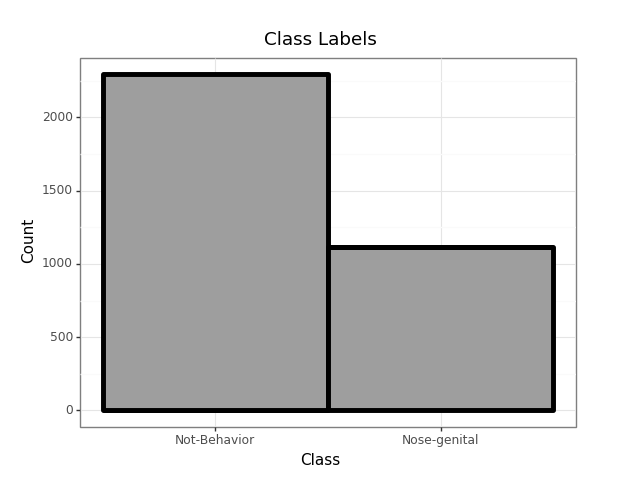

<IPython.core.display.Javascript object>


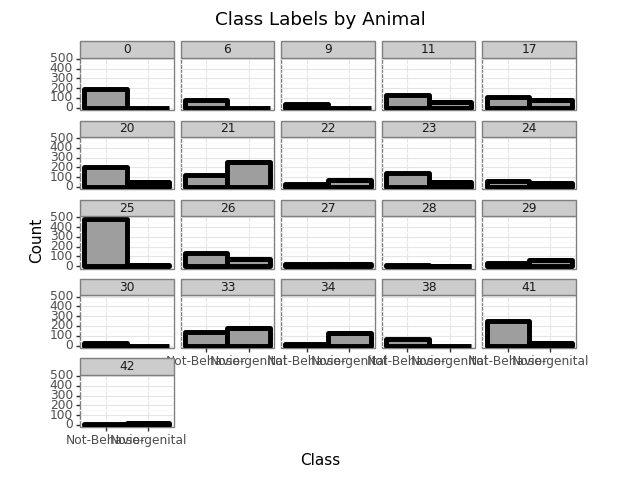

In [8]:
plotting_df = pd.DataFrame(
    {
        "annotations": all_labels,
        "bout": bout_data,
        "animal": annotation_animal,
        "annotation_idx": np.arange(len(all_labels)),
    }
)
# Histogram of the class labels
plot_labels = (
    p9.ggplot()
    + p9.geom_histogram(
        mapping=p9.aes(x="factor(annotations)"),
        data=plotting_df,
        bins=2,
        fill="#9e9e9e",
        color="#000000",
        size=2,
    )
    + p9.labs(title="Class Labels", x="Class", y="Count")
    + p9.scale_x_discrete(labels=["Not-Behavior", behavior])
    + p9.theme_bw()
)
plot_labels.draw().show()

# Class labels per-animal
plot_animals = (
    p9.ggplot()
    + p9.geom_histogram(
        mapping=p9.aes(x="factor(annotations)"),
        data=plotting_df,
        bins=2,
        fill="#9e9e9e",
        color="#000000",
        size=2,
    )
    + p9.labs(title="Class Labels by Animal", x="Class", y="Count")
    + p9.scale_x_discrete(labels=["Not-Behavior", behavior])
    + p9.facet_wrap("animal")
    + p9.theme_bw()
)
plot_animals.draw().show()

## Step 4

Splitting the training data into train and validation

We will be using the training portion of the data to allow the algorithm to learn the best parameters to make predictions

The validation will be held out to evaluate performance of the classifier

Here we define a handful of functions that accepts the features and labels and returns the split data

In [9]:
# Defining functions to split the data
# Here we're going to manually shuffle and split
# Naive approach 1 - random sorted split (deterministic)
def split_data(features, labels, percent_train=0.75):
    available_examples = np.arange(len(labels))
    train_idxs = available_examples[: int(len(labels) * percent_train)]
    test_idxs = available_examples[int(len(labels) * percent_train) :]
    # Separate out the training data
    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    # Separate out the validation data
    valid_features = features[test_idxs]
    valid_labels = labels[test_idxs]
    return train_features, train_labels, valid_features, valid_labels

In [10]:
# Naive approach 2 - random shuffle
def random_split_data(features, labels, percent_train=0.75):
    available_examples = np.arange(len(labels))
    np.random.shuffle(available_examples)
    train_idxs = available_examples[: int(len(labels) * percent_train)]
    test_idxs = available_examples[int(len(labels) * percent_train) :]
    # Separate out the training data
    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    # Separate out the validation data
    valid_features = features[test_idxs]
    valid_labels = labels[test_idxs]
    return train_features, train_labels, valid_features, valid_labels

In [11]:
# Using sklearn to split the data
# Stratified splitting:
# Attempts to preserve the train/valid class representations
def sklearn_stratified_split(features, labels, percent_train=0.75):
    train_idxs, test_idxs = list(
        sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, train_size=percent_train).split(
            features, labels
        )
    )[0]
    # Separate out the training data
    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    # Separate out the validation data
    valid_features = features[test_idxs]
    valid_labels = labels[test_idxs]
    return train_features, train_labels, valid_features, valid_labels

In [12]:
# Group splitting
# Leaves one group out within the split
# Note that this one group that is left out is not guaranteed to contain both labels, so sometime performance will contain things like division by 0.
def sklearn_logo_split(features, labels, groups, percent_train=0.75):
    train_idxs, test_idxs = list(
        sklearn.model_selection.LeaveOneGroupOut().split(features, labels, groups)
    )[0]
    # Separate out the training data
    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    # Separate out the validation data
    valid_features = features[test_idxs]
    valid_labels = labels[test_idxs]
    return train_features, train_labels, valid_features, valid_labels

In [13]:
# Group splitting #2
# Leaves multiple groups out with a target percent annotations that fall into the training set
def sklearn_group_split(features, labels, groups, percent_train=0.75):
    train_idxs, test_idxs = list(
        sklearn.model_selection.GroupShuffleSplit(n_splits=1, train_size=percent_train).split(
            features, labels, groups
        )
    )[0]
    # Separate out the training data
    train_features = features[train_idxs]
    train_labels = labels[train_idxs]
    # Separate out the validation data
    valid_features = features[test_idxs]
    valid_labels = labels[test_idxs]
    return train_features, train_labels, valid_features, valid_labels

## Experiment 1

Inspect/Visualize the effects of different splits of the annotations

<IPython.core.display.Javascript object>


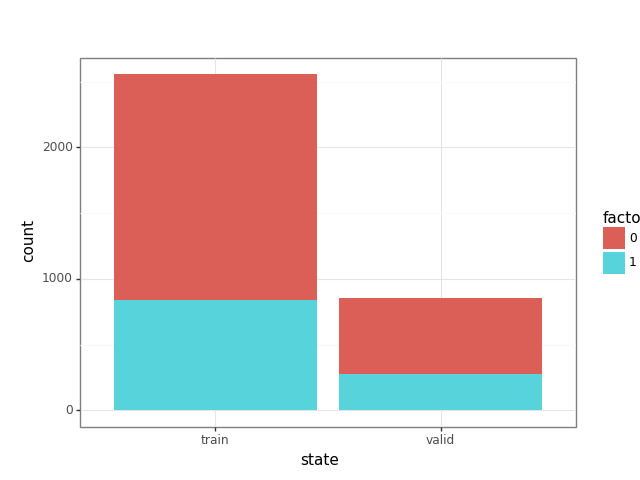

In [14]:
# Random split
train_features, train_labels, valid_features, valid_labels = random_split_data(
    all_features, all_labels
)
# Stratified split
# train_features, train_labels, valid_features, valid_labels =sklearn_stratified_split(all_features, all_labels)
# Leave one group out split (bout)
# train_features, train_labels, valid_features, valid_labels = sklearn_logo_split(all_features, all_labels, bout_data)
# Leave one group out split (animal)
# train_features, train_labels, valid_features, valid_labels = sklearn_logo_split(all_features, all_labels, annotation_animal)
# Leave multiple groups out (bouts)
# train_features, train_labels, valid_features, valid_labels = sklearn_group_split(all_features, all_labels, bout_data)
# Leave multiple groups out (animals)
# train_features, train_labels, valid_features, valid_labels = sklearn_group_split(all_features, all_labels, annotation_animal)

train_df = pd.DataFrame({"state": "train", "label": train_labels})
valid_df = pd.DataFrame({"state": "valid", "label": valid_labels})
plot_df = pd.concat([train_df, valid_df])

split_plot = (
    p9.ggplot(plot_df) + p9.geom_bar(p9.aes(x="state", fill="factor(label)")) + p9.theme_bw()
)

split_plot.draw().show()

## Label Balancing

Since we're aware that we have roughly a 3x more annotations for not-behavior, we should probably consider balancing the labels

We can take multiple approaches to creating a more balanced dataset:
1. Downsampling: Discard data from the class which has the most annotation until the labels are balanced
2. Upsampling: Duplicate data from the class which has the least annotation until the labels are balanced

In [15]:
# Downsamples the featuers, labels, and groups such that the labels are balanced
def downsample_balanced(features, labels, groups=None):
    _, label_counts = np.unique(labels, return_counts=True)
    # Since we want to discard samples, we should pick the smaller of the 2 class sizes
    smallest_class_count = np.min(label_counts)
    class_0_idxs = np.where(labels == 0)[0]
    class_1_idxs = np.where(labels == 1)[0]
    # Here we can randomly choose without replacement examples
    class_0_idxs = np.random.choice(class_0_idxs, smallest_class_count, replace=False)
    class_1_idxs = np.random.choice(class_1_idxs, smallest_class_count, replace=False)
    selected_samples = np.sort(np.concatenate([class_0_idxs, class_1_idxs]))
    new_features = features[selected_samples, :]
    new_labels = labels[selected_samples]
    if groups is not None:
        new_groups = groups[selected_samples]
        return new_features, new_labels, new_groups
    else:
        return new_features, new_labels, None

### Question 5

Write a function to upsample the data
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-5)

In [16]:
# Downsamples the featuers, labels, and groups such that the labels are balanced
def upsample_balanced(features, labels, groups=None):
    _, label_counts = np.unique(labels, return_counts=True)
    largest_class_count = np.max(label_counts)
    class_0_idxs = np.where(labels == 0)[0]
    class_1_idxs = np.where(labels == 1)[0]
    class_0_idxs = np.random.choice(class_0_idxs, largest_class_count, replace=True)
    class_1_idxs = np.random.choice(class_1_idxs, largest_class_count, replace=True)
    selected_samples = np.sort(np.concatenate([class_0_idxs, class_1_idxs]))
    new_features = features[selected_samples, :]
    new_labels = labels[selected_samples]
    if groups is not None:
        new_groups = groups[selected_samples]
        return new_features, new_labels, new_groups
    else:
        return new_features, new_labels, None

## Experiment 2

Inspect/Visualize the effects of downsampling the annotations

<IPython.core.display.Javascript object>


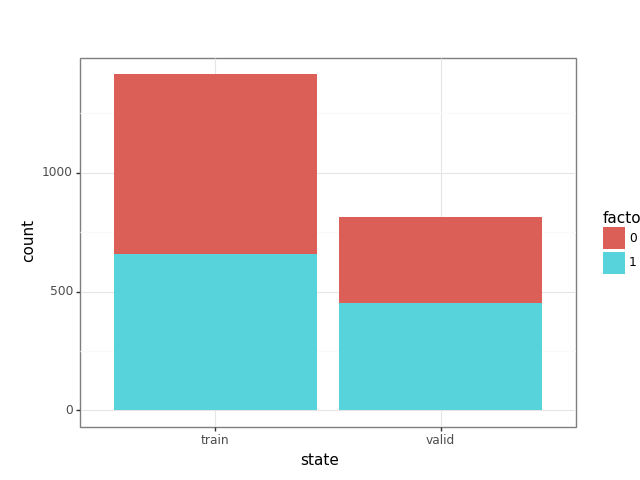

In [17]:
# Downsample
balanced_features, balanced_labels, balanced_groups = downsample_balanced(
    all_features, all_labels, annotation_animal
)
# Upsample
# balanced_features, balanced_labels, balanced_groups = upsample_balanced(all_features, all_labels, annotation_animal)
train_features, train_labels, valid_features, valid_labels = sklearn_group_split(
    balanced_features, balanced_labels, balanced_groups
)
train_df = pd.DataFrame({"state": "train", "label": train_labels})
valid_df = pd.DataFrame({"state": "valid", "label": valid_labels})
plot_df = pd.concat([train_df, valid_df])

split_plot = (
    p9.ggplot(plot_df) + p9.geom_bar(p9.aes(x="state", fill="factor(label)")) + p9.theme_bw()
)

split_plot.draw().show()

## Step 5

Train classifiers

For the purposes of this tutorial, we will be relying on using SKLearn to training classifiers.

Good recommended classifiers:
1. [Adaboost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn-ensemble-adaboostclassifier)
2. [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier)

In [18]:
# Define how to train a decision tree classifier
def train_dt_classifier(train_features, train_labels):
    # Create a classifier object
    # Note here we are using a bunch of default values that SKLearn has picked for us.
    # Check the documentation of the various parameters you can adjust for the decision trees:
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier
    classifier = sklearn.tree.DecisionTreeClassifier()
    # Train the classifier on our training features + labels
    classifier = classifier.fit(train_features, train_labels)
    return classifier

### Question 6

Write functions to train an adaboost and random forest classifier
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-6)

In [19]:
# Adaboost Classifier
def train_ada_classifier(train_features, train_labels):
    classifier = sklearn.ensemble.AdaBoostClassifier()
    classifier = classifier.fit(train_features, train_labels)
    return classifier

In [20]:
# Random forest Classifier
def train_rf_classifier(train_features, train_labels):
    classifier = sklearn.ensemble.RandomForestClassifier()
    classifier = classifier.fit(train_features, train_labels)
    return classifier

## Step 6

Frame-wise evaluation of the classifier

Since our classifier predicts for every frame, we can estimate its performance by comparing the held-out validation data with the predictions it is making.

For evaluating classifier performance, we must first calculate the 4 values of a confusion matrix:
1. True positives (TP): When both the classifier and the ground truth assign "behavior"
2. False negatives (FN): When the classifier predicts "not behavior" and the ground truth assigns "behavior"
3. False positives (FP): When the classifier predicts "behavior" and the ground truth assigns "not behavior"
4. True negatives (TN): When both the classifier and the ground truth assign "not behavior"

From these, we can calculate 4 additional useful performance metrics for describing the classifier. Wikipedia has a [good article](https://en.wikipedia.org/wiki/Precision_and_recall) outlining these as well as more, but these are the 4 most common.
1. Accuracy: The total number of predictions that were correct.
    * (TP+TN)/(TP+TN+FP+FN)
2. Precision: Of the predictions for "behavior", how many were correct?
    * TP/(TP+FP)
3. Recall: Of the ground truths labeled "behavior", how many did the classifier predict?
    * TP/(TP+FN)
4. F-beta (F1, F-score): Harmonic mean of precision and recall 
    * 2 * (Pr * Re)/(Pr+Re)

### Question 7

Complete the definitions of the confusion matrix and the performance metrics below
[Solution](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Question-7)

In [21]:
# Routine for evaluating the classifier performance
def eval_classifier_performance(classifier, features, labels, print_results=True):
    # Predict on held-out set
    predictions = classifier.predict(features)
    # Accuracy
    acc = np.mean(predictions == labels)
    # Confusion matrix values for a binary classifier
    tp_count = np.sum(np.logical_and(predictions == 1, labels == 1))
    tn_count = np.sum(np.logical_and(predictions == 0, labels == 0))
    fp_count = np.sum(np.logical_and(predictions == 1, labels == 0))
    fn_count = np.sum(np.logical_and(predictions == 0, labels == 1))
    # Calculate other metrics
    # Of the predictions we made, how many were correct
    precision = tp_count / (tp_count + fp_count)
    # Of the things we were looking for, how many did we find
    recall = tp_count / (tp_count + fn_count)
    # Harmonic mean of Pr and Re
    f1 = 2 * (precision * recall) / (precision + recall)
    if print_results:
        print("Accuracy: " + str(acc))
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1-score: " + str(f1))
    # We can also show that sklearn has tools for providing these metrics
    # Note that we've calculated the "precision" and "recall" for the behavior (value == 1)
    # print(sklearn.metrics.classification_report(labels, predictions))
    # Manually obtaining each
    # sklearn.metrics.precision_score(labels, predictions)
    # sklearn.metrics.recall_score(labels, predictions)
    # sklearn.metrics.f1_score(labels, predictions)
    return acc, precision, recall, f1

## Step 7

Run through the steps:
1. Split the training data into train/valid
2. Train a classifier on the train portion of the split
3. Evaluate the classifier

In [22]:
# Step 1: Split the data into train/valid
train_features, train_labels, valid_features, valid_labels = random_split_data(
    all_features, all_labels
)
# Train a classifier
dt_classifier = train_dt_classifier(train_features, train_labels)
# Evaluate the classifier
eval_classifier_performance(dt_classifier, valid_features, valid_labels)
# Repeat these steps to test how different parameters influence performance

Accuracy: 0.9612676056338029
Precision: 0.9550173010380623
Recall: 0.9324324324324325
F1-score: 0.9435897435897436


(0.9612676056338029,
 0.9550173010380623,
 0.9324324324324325,
 0.9435897435897436)

## Experiment 3

See performance of different classifiers and sampling strategies

In [23]:
# Sampling options:
# Random split
# train_features, train_labels, valid_features, valid_labels = random_split_data(all_features, all_labels)
# Stratified split
# train_features, train_labels, valid_features, valid_labels =sklearn_stratified_split(all_features, all_labels)
# Leave one group out split (bout)
# train_features, train_labels, valid_features, valid_labels = sklearn_logo_split(all_features, all_labels, bout_data)
# Leave one group out split (animal)
# train_features, train_labels, valid_features, valid_labels = sklearn_logo_split(all_features, all_labels, annotation_animal)
# Leave multiple groups out (bouts)
# train_features, train_labels, valid_features, valid_labels = sklearn_group_split(all_features, all_labels, bout_data)
# Leave multiple groups out (animals)
# train_features, train_labels, valid_features, valid_labels = sklearn_group_split(all_features, all_labels, annotation_animal)
# Example with extra step for balanced labels + group sampling
balanced_features, balanced_labels, balanced_groups = downsample_balanced(
    all_features, all_labels, annotation_animal
)
train_features, train_labels, valid_features, valid_labels = sklearn_group_split(
    balanced_features, balanced_labels, balanced_groups
)

# Classifier options:
# Decision Tree
# classifier = train_dt_classifier(train_features, train_labels)
# Ada Boost
# classifier = train_ada_classifier(train_features, train_labels)
# Random Forest
classifier = train_rf_classifier(train_features, train_labels)

# Run the evaluation!
eval_classifier_performance(classifier, valid_features, valid_labels)

Accuracy: 0.7627118644067796
Precision: 0.9226361031518625
Recall: 0.6376237623762376
F1-score: 0.7540983606557377


(0.7627118644067796,
 0.9226361031518625,
 0.6376237623762376,
 0.7540983606557377)

## Experiment 4

Expand the search of parameters by also adjusting the parameters of the model, eg the number of trees in the random forest.

We provide an example structure for looping through 10 training splits for the decision tree classifier.

Suggested tests:
1. Change the classifier type
2. Change the train/valid split approach
3. Include balanced data
4. Test various parameters of the classifier

In [24]:
all_results = []
# random splits
for test_model in np.arange(10):
    train_features, train_labels, valid_features, valid_labels = random_split_data(
        all_features, all_labels
    )
    dt_classifier = train_dt_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        dt_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["decision tree"],
                "split_method": ["random"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    ada_classifier = train_ada_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        ada_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["ada boost"],
                "split_method": ["random"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    rf_classifier = train_rf_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        rf_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["random forest"],
                "split_method": ["random"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )

# leave bouts out splits
for test_model in np.arange(10):
    train_features, train_labels, valid_features, valid_labels = sklearn_group_split(
        all_features, all_labels, bout_data
    )
    dt_classifier = train_dt_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        dt_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["decision tree"],
                "split_method": ["leave bouts out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    ada_classifier = train_ada_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        ada_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["ada boost"],
                "split_method": ["leave bouts out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    rf_classifier = train_rf_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        rf_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["random forest"],
                "split_method": ["leave bouts out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )

# leave animals out splits
for test_model in np.arange(10):
    train_features, train_labels, valid_features, valid_labels = sklearn_group_split(
        all_features, all_labels, annotation_animal
    )
    dt_classifier = train_dt_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        dt_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["decision tree"],
                "split_method": ["leave animal out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    ada_classifier = train_ada_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        ada_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["ada boost"],
                "split_method": ["leave animal out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )
    rf_classifier = train_rf_classifier(train_features, train_labels)
    acc, pr, re, f1 = eval_classifier_performance(
        rf_classifier, valid_features, valid_labels, print_results=False
    )
    all_results.append(
        pd.DataFrame(
            {
                "classifier": ["random forest"],
                "split_method": ["leave animal out"],
                "accuracy": [acc],
                "precision": [pr],
                "recall": [re],
                "f1": [f1],
            }
        )
    )

# Flatten the list of dataframes into one
results_df = pd.concat(all_results)

Inspect the results of your scan(s)

<IPython.core.display.Javascript object>


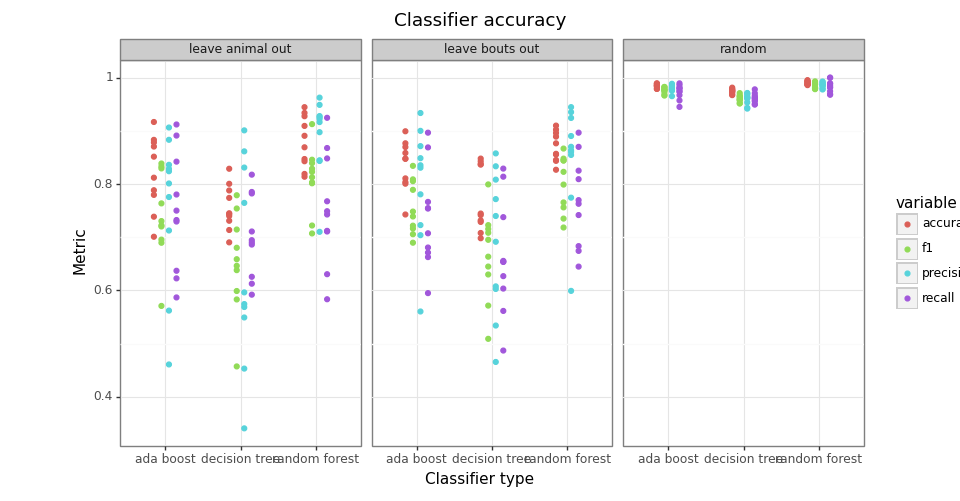

In [25]:
melted_df = pd.melt(
    results_df,
    id_vars=["classifier", "split_method"],
    value_vars=["accuracy", "precision", "recall", "f1"],
)
performance_plot = (
    p9.ggplot(data=melted_df)
    + p9.geom_point(
        p9.aes(x="classifier", y="value", color="variable"), position=p9.position_dodge(width=0.4)
    )
    + p9.facet_wrap("split_method")
    + p9.labs(title="Classifier accuracy", x="Classifier type", y="Metric")
    + p9.theme_bw()
)

performance_plot.draw().show()

## Step 8

Evaluate your best classifier on the held-out test dataset

You could also potentially just train a classifier on the entire training set (after you've tuned the numbers with the validation set)

In [26]:
# best_classifier = dt_classifier
best_classifier = train_rf_classifier(all_features, all_labels)
eval_classifier_performance(best_classifier, test_features, test_labels)

Accuracy: 0.981574074074074
Precision: 0.7323151125401929
Recall: 0.6630276564774381
F1-score: 0.6959511077158136


(0.981574074074074, 0.7323151125401929, 0.6630276564774381, 0.6959511077158136)

You may observe that performance has dropped a bit, but if you selected the correct train/valid split approach and didn't over-fit on your validation data, it should still perform well.

## Discussion 2

Up until now, we've been focussing on frame-level agreement, which is simple enough for training classifiers.

Are there better ways to evaluate performance of a behavior classifier?

[Discussion Notes](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Discussion-2)


One approach could be evaluating dense annotations for bout-level agreement
Other notes on the importance of bout-level agreement -- eg filter/stitching/other post-processing steps


## Step 9

Bout-level agreement on dense annotation

In order to measure bout-level agreement, we need to transform the data into starts and ends

We can either write the detection of bouts within predictions manually or re-use a classical compression algorithm called run length encoding

Note that typical RLE algorithms will encode all states (both "behavior" and "not-behavior"), while we primarily care about only 1 of the 2 states.

In [27]:
# Run length encoding, implemented using numpy
# Accepts a 1d vector
# Returns a tuple containing (starts, durations, values)
def rle(inarray):
    ia = np.asarray(inarray)
    n = len(ia)
    if n == 0:
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]
        i = np.append(np.where(y), n - 1)
        z = np.diff(np.append(-1, i))
        p = np.cumsum(np.append(0, z))[:-1]
        return (p, z, ia[i])

Use the RLE algorithm to encode predictions

We also need to separate the data by animal, because bouts can only exist within animal

In [28]:
test_predictions = best_classifier.predict(test_features)

# Arrays to store the list of bouts by animal
all_pr_bouts = []
all_gt_bouts = []
# Loop over each animal and add their bouts to the lists
for animal_id in np.unique(test_animals):
    animal_indices = test_animals == animal_id
    test_bout_predictions = rle(test_predictions[animal_indices])
    # Only store the bouts of behavior
    behavior_bouts = test_bout_predictions[2] == 1
    if np.any(behavior_bouts):
        test_bout_predictions = (
            test_bout_predictions[0][behavior_bouts],
            test_bout_predictions[1][behavior_bouts],
        )
        all_pr_bouts.append(test_bout_predictions)
    else:
        all_pr_bouts.append(([], []))
    test_bout_gt = rle(test_labels[animal_indices])
    # Only store the bouts of behavior
    behavior_bouts = test_bout_gt[2] == 1
    if np.any(behavior_bouts):
        test_bout_gt = (test_bout_gt[0][behavior_bouts], test_bout_gt[1][behavior_bouts])
        all_gt_bouts.append(test_bout_gt)
    else:
        all_gt_bouts.append(([], []))

Display the predictions next to their GT

<IPython.core.display.Javascript object>


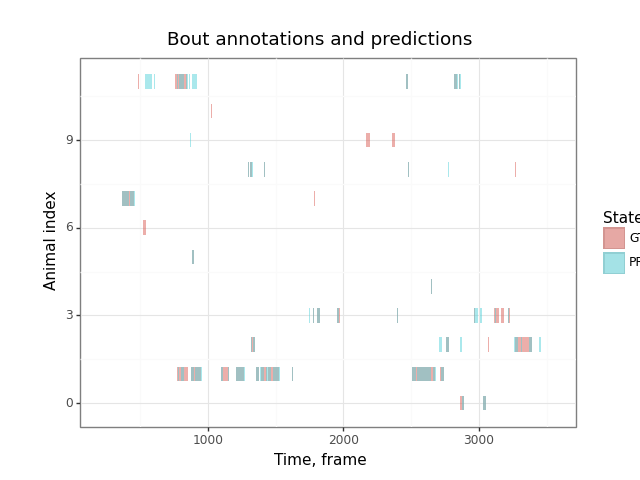

In [29]:
bout_data = []
for animal_idx, animal_id in enumerate(np.unique(test_animals)):
    gt_bout_data = all_gt_bouts[animal_idx]
    if len(gt_bout_data[0]) > 0:
        gt_bout_df = pd.DataFrame(
            {
                "state": "GT",
                "animal": animal_id,
                "animal_idx": animal_idx,
                "start_time": gt_bout_data[0],
                "end_time": gt_bout_data[0] + gt_bout_data[1],
            }
        )
        bout_data.append(gt_bout_df)
    pr_bout_data = all_pr_bouts[animal_idx]
    if len(pr_bout_data[0]) > 0:
        pr_bout_df = pd.DataFrame(
            {
                "state": "PR",
                "animal": animal_id,
                "animal_idx": animal_idx,
                "start_time": pr_bout_data[0],
                "end_time": pr_bout_data[0] + pr_bout_data[1],
            }
        )
        bout_data.append(pr_bout_df)

bout_data = pd.concat(bout_data)
bout_plot = (
    p9.ggplot(bout_data)
    + p9.geom_rect(
        p9.aes(
            xmin="start_time",
            xmax="end_time",
            ymin="animal_idx-0.25",
            ymax="animal_idx+0.25",
            fill="factor(state)",
        ),
        alpha=0.5,
    )
    + p9.labs(
        title="Bout annotations and predictions", x="Time, frame", y="Animal index", fill="State"
    )
    + p9.theme_bw()
)

bout_plot.draw().show()

## Step 10

Strategies for evaluating performance of bout-based metrics

Since predictions are almost never going to be identical to the ground truth, we need to adjust our strategy for calling correct and incorrect classifications of the confusion matrix. To do this, we should attempt to detect how much the predictions overlap.

In classical image processing, this was done via calculating the intersection over union (IoU) between predictions and ground truth. We can adopt the same technique for our 1-D problem (time).

In [30]:
# Calculates the intersection of 2 bouts
# Each bout is a tuple of (start, duration)
def calculate_intersection(gt_bout, pr_bout):
    # Detect the larger of the 2 start times
    max_start_time = np.max([gt_bout[0], pr_bout[0]])
    # Detect the smaller of the 2 end times
    gt_bout_end = gt_bout[0] + gt_bout[1]
    pr_bout_end = pr_bout[0] + pr_bout[1]
    min_end_time = np.min([gt_bout_end, pr_bout_end])
    # Detect if the 2 bouts intersected at all
    if max_start_time < min_end_time:
        return min_end_time - max_start_time
    else:
        return 0


# Calculates the union of 2 bouts
# Each bout is a tuple of (start, duration)
def calculate_union(gt_bout, pr_bout):
    # If the 2 don't intersect, we can just sum up the durations
    if calculate_intersection(gt_bout, pr_bout) == 0:
        return gt_bout[1] + pr_bout[1]
    # They do intersect
    else:
        min_start_time = np.min([gt_bout[0], pr_bout[0]])
        gt_bout_end = gt_bout[0] + gt_bout[1]
        pr_bout_end = pr_bout[0] + pr_bout[1]
        max_end_time = np.max([gt_bout_end, pr_bout_end])
        return max_end_time - min_start_time

In [31]:
all_intersections = []
all_unions = []
all_ious = []

# Loop over the animals again
num_test_animals = len(np.unique(test_animals))
for animal_idx in np.arange(num_test_animals):
    # For each animal, we want a matrix of intersections, unions, and ious
    num_gt_bouts = len(all_gt_bouts[animal_idx][0])
    num_pr_bouts = len(all_pr_bouts[animal_idx][0])
    animal_intersection_mat = np.zeros([num_gt_bouts, num_pr_bouts])
    animal_union_mat = np.zeros([num_gt_bouts, num_pr_bouts])
    # Do a second loop for each GT bout
    for gt_idx in np.arange(num_gt_bouts):
        gt_bout = [all_gt_bouts[animal_idx][0][gt_idx], all_gt_bouts[animal_idx][1][gt_idx]]
        # Final loop for each proposed bout
        for pr_idx in np.arange(num_pr_bouts):
            pr_bout = [all_pr_bouts[animal_idx][0][pr_idx], all_pr_bouts[animal_idx][1][pr_idx]]
            # Calculate the intersections, unions, and IoUs
            animal_intersection_mat[gt_idx, pr_idx] = calculate_intersection(gt_bout, pr_bout)
            animal_union_mat[gt_idx, pr_idx] = calculate_union(gt_bout, pr_bout)
    # The IoU matrix will just be i / u
    animal_iou_mat = animal_intersection_mat / animal_union_mat
    # Add the animal data to the resulting lists
    all_intersections.append(animal_intersection_mat)
    all_unions.append(animal_union_mat)
    all_ious.append(animal_iou_mat)

Now that we have IoUs, we can try and apply thresholds for calculating things like precision/recall
Since it's hard to define "True Negatives" with the IoU technique, we can skip that for now

In [32]:
# Define detection metrics, given a IoU threshold
def calc_temporal_iou_metrics(iou_data, threshold):
    tp_counts = 0
    fn_counts = 0
    fp_counts = 0
    for cur_iou_mat in iou_data:
        tp_counts += np.sum(np.any(cur_iou_mat > threshold, axis=1))
        fn_counts += np.sum(np.all(cur_iou_mat < threshold, axis=1))
        fp_counts += np.sum(np.all(cur_iou_mat < threshold, axis=0))
    precision = tp_counts / (tp_counts + fp_counts)
    recall = tp_counts / (tp_counts + fn_counts)
    f1 = 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

<IPython.core.display.Javascript object>


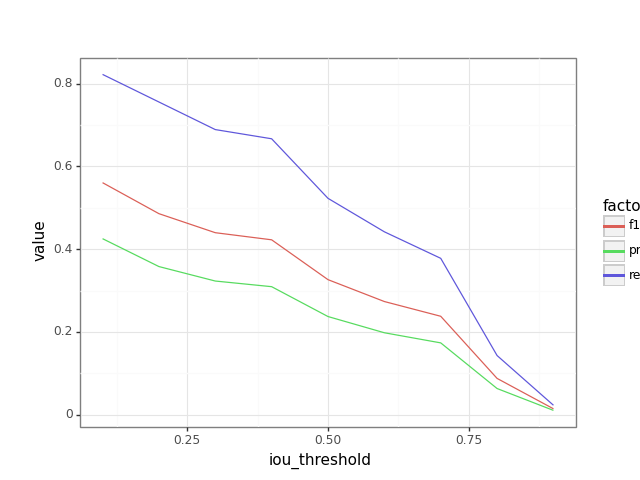

In [33]:
all_iou_results = []

ious_to_evaluate = all_ious

for cur_iou in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    performance = calc_temporal_iou_metrics(ious_to_evaluate, cur_iou)
    all_iou_results.append(
        pd.DataFrame(
            {
                "iou_threshold": [cur_iou],
                "precision": [performance[0]],
                "recall": [performance[1]],
                "f1": [performance[2]],
            }
        )
    )

iou_df = pd.concat(all_iou_results)
iou_df = pd.melt(iou_df, id_vars=["iou_threshold"], value_vars=["precision", "recall", "f1"])

iou_plot = (
    p9.ggplot(iou_df)
    + p9.geom_line(p9.aes(x="iou_threshold", y="value", color="factor(variable)"))
    + p9.theme_bw()
)

iou_plot.draw().show()

## Discussion 3

Pros and Cons to bout based analysis

False positives are overestimated, because there may be multiple predicted bouts within 1 real bout.

Are there potential methods to try and fix this issue?

[Discussion Notes](http://localhost:8888/notebooks/ML-Course-2022-JABS_SOLUTIONS.ipynb#Discussion-3)

Possible techniques include:
1. Filtering out short/spurious predictions
2. Stitching together multiple predictions close in time
3. Adjusting what we're calling TP/FN/FP to be more lenient on the exact number of bouts

## Step 11

Post-processing techniques

In [34]:
def merge_behavior_gaps(
    bout_starts, bout_durations, bout_states, max_gap_size, state_to_merge=False
):
    gaps_to_remove = np.logical_and(bout_states == state_to_merge, bout_durations < max_gap_size)
    new_durations = np.copy(bout_durations)
    new_starts = np.copy(bout_starts)
    new_states = np.copy(bout_states)
    if np.any(gaps_to_remove):
        # Go through backwards removing gaps
        for cur_gap in np.where(gaps_to_remove)[0][::-1]:
            # Nothing earlier or later to join together, ignore
            if cur_gap == 0 or cur_gap == len(new_durations) - 1:
                pass
            else:
                cur_duration = np.sum(new_durations[cur_gap - 1 : cur_gap + 2])
                new_durations[cur_gap - 1] = cur_duration
                new_durations = np.delete(new_durations, [cur_gap, cur_gap + 1])
                new_starts = np.delete(new_starts, [cur_gap, cur_gap + 1])
                new_states = np.delete(new_states, [cur_gap, cur_gap + 1])
    return new_starts, new_durations, new_states

## Experiment 5

Test performance across multiple filtering parameters
Run the next 2 cells and change the 2 variables at the top to be more/less stringent on bouts

In [35]:
# Filter out short bouts
min_bout_duration = 9
# Remove short breaks in bouts
min_gap_duration = 5

filtered_pr_bouts = []
for animal_id in np.unique(test_animals):
    animal_indices = test_animals == animal_id
    raw_bout_predictions = rle(test_predictions[animal_indices])
    # Remove short breaks in bouts
    filtered_bout_predictions = merge_behavior_gaps(
        raw_bout_predictions[0],
        raw_bout_predictions[1],
        raw_bout_predictions[2],
        min_bout_duration,
        state_to_merge=False,
    )
    # Filter out short bouts
    filtered_bout_predictions = merge_behavior_gaps(
        filtered_bout_predictions[0],
        filtered_bout_predictions[1],
        filtered_bout_predictions[2],
        min_bout_duration,
        state_to_merge=True,
    )
    behavior_bouts = filtered_bout_predictions[2] == 1
    if np.any(behavior_bouts):
        filtered_bout_predictions = (
            filtered_bout_predictions[0][behavior_bouts],
            filtered_bout_predictions[1][behavior_bouts],
        )
        filtered_pr_bouts.append(filtered_bout_predictions)
    else:
        filtered_pr_bouts.append(([], []))

filtered_intersections = []
filtered_unions = []
filtered_ious = []

# Loop over the animals again
num_test_animals = len(np.unique(test_animals))
for animal_idx in np.arange(num_test_animals):
    # For each animal, we want a matrix of intersections, unions, and ious
    num_gt_bouts = len(all_gt_bouts[animal_idx][0])
    num_pr_bouts = len(filtered_pr_bouts[animal_idx][0])
    animal_intersection_mat = np.zeros([num_gt_bouts, num_pr_bouts])
    animal_union_mat = np.zeros([num_gt_bouts, num_pr_bouts])
    # Do a second loop for each GT bout
    for gt_idx in np.arange(num_gt_bouts):
        gt_bout = [all_gt_bouts[animal_idx][0][gt_idx], all_gt_bouts[animal_idx][1][gt_idx]]
        # Final loop for each proposed bout
        for pr_idx in np.arange(num_pr_bouts):
            pr_bout = [
                filtered_pr_bouts[animal_idx][0][pr_idx],
                filtered_pr_bouts[animal_idx][1][pr_idx],
            ]
            # Calculate the intersections, unions, and IoUs
            animal_intersection_mat[gt_idx, pr_idx] = calculate_intersection(gt_bout, pr_bout)
            animal_union_mat[gt_idx, pr_idx] = calculate_union(gt_bout, pr_bout)
    # The IoU matrix will just be i / u
    animal_iou_mat = animal_intersection_mat / animal_union_mat
    # Add the animal data to the resulting lists
    filtered_intersections.append(animal_intersection_mat)
    filtered_unions.append(animal_union_mat)
    filtered_ious.append(animal_iou_mat)

Plot the performance with post-processing!

<IPython.core.display.Javascript object>


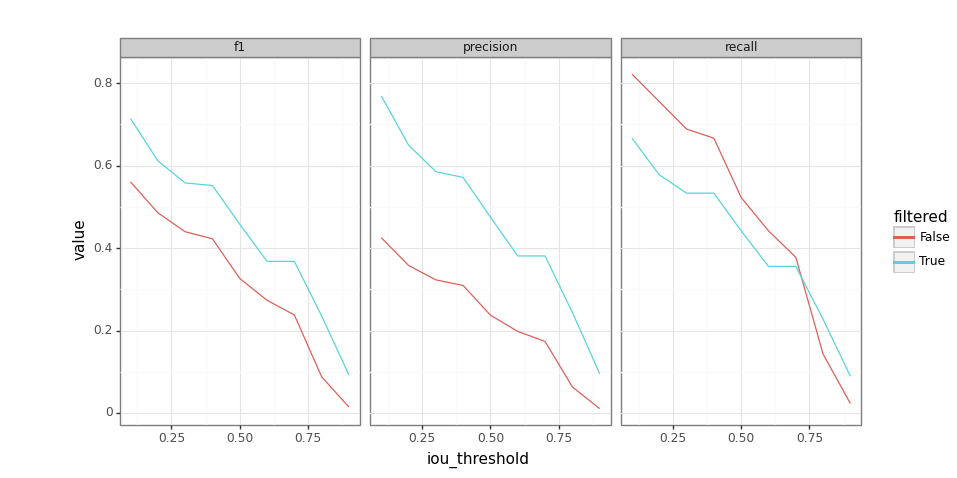

In [36]:
all_iou_results = []

for cur_iou in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    performance = calc_temporal_iou_metrics(filtered_ious, cur_iou)
    all_iou_results.append(
        pd.DataFrame(
            {
                "iou_threshold": [cur_iou],
                "precision": [performance[0]],
                "recall": [performance[1]],
                "f1": [performance[2]],
            }
        )
    )

iou_df_filtered = pd.concat(all_iou_results)
iou_df_filtered = pd.melt(
    iou_df_filtered, id_vars=["iou_threshold"], value_vars=["precision", "recall", "f1"]
)

iou_df_filtered["filtered"] = True
iou_df["filtered"] = False
iou_df_filtered = pd.concat([iou_df_filtered, iou_df])


iou_plot = (
    p9.ggplot(iou_df_filtered)
    + p9.geom_line(p9.aes(x="iou_threshold", y="value", color="filtered"))
    + p9.facet_wrap("variable")
    + p9.theme_bw()
)


iou_plot.draw().show()

<IPython.core.display.Javascript object>


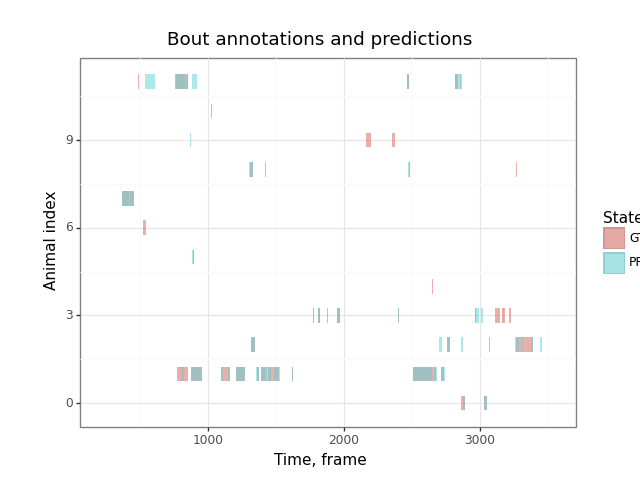

In [37]:
bout_data = []
for animal_idx, animal_id in enumerate(np.unique(test_animals)):
    gt_bout_data = all_gt_bouts[animal_idx]
    if len(gt_bout_data[0]) > 0:
        gt_bout_df = pd.DataFrame(
            {
                "state": "GT",
                "animal": animal_id,
                "animal_idx": animal_idx,
                "start_time": gt_bout_data[0],
                "end_time": gt_bout_data[0] + gt_bout_data[1],
            }
        )
        bout_data.append(gt_bout_df)
    pr_bout_data = filtered_pr_bouts[animal_idx]
    if len(pr_bout_data[0]) > 0:
        pr_bout_df = pd.DataFrame(
            {
                "state": "PR",
                "animal": animal_id,
                "animal_idx": animal_idx,
                "start_time": pr_bout_data[0],
                "end_time": pr_bout_data[0] + pr_bout_data[1],
            }
        )
        bout_data.append(pr_bout_df)

bout_data = pd.concat(bout_data)
bout_plot = (
    p9.ggplot(bout_data)
    + p9.geom_rect(
        p9.aes(
            xmin="start_time",
            xmax="end_time",
            ymin="animal_idx-0.25",
            ymax="animal_idx+0.25",
            fill="factor(state)",
        ),
        alpha=0.5,
    )
    + p9.labs(
        title="Bout annotations and predictions", x="Time, frame", y="Animal index", fill="State"
    )
    + p9.theme_bw()
)

bout_plot.draw().show()